In [ ]:
# 2025-4-20 run it in "pytohn 3 base env" on ins-gl-pt-gpu24-2c94136-3env-j4-l4-test-1 with 1 L4 GPU


# CubeDiff: Training Pipeline

This notebook demonstrates the training pipeline for CubeDiff:

1. Configure training parameters
2. Initialize the model and training components
3. Train on a small dataset
4. Monitor training progress
5. Save checkpoints

In [1]:
!pip install diffusers==0.24.0 transformers==4.36.2 torch==2.1.2 torchvision==0.16.2 accelerate==0.25.0 \
    opencv-python==4.8.1.78 opencv-contrib-python==4.8.1.78 matplotlib==3.8.2 tqdm==4.66.1 einops==0.7.0 \
    huggingface_hub==0.19.4 opencv-python xformers requests pillow openexr opencv-python-headless wandb

  Using cached diffusers-0.24.0-py3-none-any.whl.metadata (18 kB)
  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.16.2-cp310-cp310-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached accelerate-0.25.0-py3-none-any.whl.metadata (18 kB)
  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Using cached einops-0.7.0-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Using cached xformers-0.0.29.post3-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (1.0 kB)
  Us

In [ ]:
import os
import sys
import numpy as np
import torch
from diffusers import StableDiffusionPipeline, DDPMScheduler
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import json
import time
import wandb

os.environ["WANDB_NOTEBOOK_NAME"] = "03_training.ipynb"

# Add parent directory to path
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

# # Import custom modules
# from model.architecture import CubeDiffModel
# from data.dataset import CubemapDataset, get_dataloader
# from training.trainer import CubeDiffTrainer
# from training.lora import add_lora_to_model


# Add the git repository location directly
repo_path = '/home/jupyter/mluser/git/llm-cv-pano-cubediff'
if os.path.exists(repo_path) and repo_path not in sys.path:
    sys.path.insert(0, repo_path)
    print(f"Added {repo_path} to Python path")

# Initialize wandb in offline mode
wandb.init(mode="offline", project="cubediff_mini")
print("Wandb initialized in offline mode")

# Import the modules directly with fixed imports
# These imports now use the absolute path style
from cl.model.architecture import CubeDiffModel
from cl.data.dataset import CubemapDataset, get_dataloader
from cl.training.trainer import CubeDiffTrainer, get_tensor_info
from cl.training.lora import add_lora_to_model
# Import the system configuration utility
from cl.training.system_config import configure_system_for_training
# Import the adaptive function (if not added to system_config.py)
from cl.training.system_config import adaptive_shm_handling, configure_system_for_training, print_model_size
from cl.training.trainer import add_memory_monitoring
from cl.training.fix_mixed_precision import fix_mixed_precision_issue

# Run system configuration and get recommended settings
recommended_settings = configure_system_for_training()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Added /home/jupyter/mluser/git/llm-cv-pano-cubediff to Python path


Wandb initialized in offline mode
Configuring system for CubeDiff training...
System: Linux
Python: 3.10.16
CPU cores: 16
GPU: NVIDIA L4 x1
GPU memory: 22.0 GB
CUDA version: 12.1

Shared memory status:
Filesystem      Size  Used Avail Use% Mounted on
shm              64M     0   64M   0% /dev/shm

Current shared memory size: 64M

⚠️ WARNING: Shared memory size is small!
To increase shared memory (requires sudo):
  sudo mount -o remount,size=16G /dev/shm

If you encounter 'bus error' or 'shared memory' errors during training:
1. Consider increasing shared memory with the command above
2. Reduce batch_size and num_workers in your config
3. Use persistent_workers=True in DataLoader

Detected NVIDIA L4 GPU - optimizing settings specifically for this hardware

Optimized settings for NVIDIA L4 GPU on GCP Vertex AI:
  batch_size: 2
  gradient_accumulation_steps: 4
  mixed_precision: fp16
  num_workers: 1
  (Shared memory available: 0.1 GB)
  ⚠️ Warning: Limited shared memory detected. Conside

## 1. Define Training Configuration

In [ ]:
# Create a configuration class
class TrainingConfig:
    def __init__(self):
        # Model config
        self.pretrained_model_name = "runwayml/stable-diffusion-v1-5"
        self.lora_rank = 16
        self.lora_alpha = 16
        self.prediction_type = "v_prediction"  # or "epsilon"
        
        # Training config - optimized for L4 GPU
        self.output_dir = "../outputs/cubediff_mini"
        self.data_dir = "../data/processed/cubemaps"
        self.captions_file = "../data/processed/captions.json"
        self.batch_size = 32  # L4 GPU should handle batch size of 2
        self.learning_rate = 1e-4
        self.min_learning_rate = 1e-6
        self.weight_decay = 0.01
        self.max_grad_norm = 1.0
        self.num_workers = 14  # Start with 2 workers for multiprocessing
        self.gradient_accumulation_steps = 4
        self.mixed_precision = "fp16"  # Keep fp16 for L4 GPU efficiency
        # Example offloading settings (syntax may vary based on the framework)
        self.offload_optimizer = True  # Offload optimizer states to CPU, Enable offloading for L4 GPU
        self.offload_parameters = True  # Offload some parameters to CPU when not in use
        # Memory optimization flags
        # self.use_attention_mask = False  # If applicable for your model
        self.use_memory_efficient_attention = True  # If supported by your model architecture
        self.gradient_checkpointing = True  # Enable gradient checkpointing to save memory

        # Logging config
        self.use_wandb = True  # Enable wandb
        self.wandb_project = "cubediff"
        self.wandb_run_name = "cubediff_mini"
        self.log_every_n_steps = 10
        self.save_every_n_steps = 100
        self.eval_every_n_steps = 100
        self.sample_every_n_steps = 250
        
        # Progressive loading (helps detect and avoid memory issues early)
        self.progressive_loading = True

config = TrainingConfig()

# Print optimized configuration
print("\nOptimized Configuration:")
print(f"Batch Size: {config.batch_size}")
print(f"Workers: {config.num_workers}")
print(f"Gradient Accumulation Steps: {config.gradient_accumulation_steps}")
print(f"Mixed Precision: {config.mixed_precision}")



Optimized Configuration:
Batch Size: 2
Workers: 2
Gradient Accumulation Steps: 4
Mixed Precision: fp16


In [3]:
def check_shared_memory():
    """
    Check available shared memory and provide recommendations for
    optimal multiprocessing settings.
    
    Returns:
        tuple: (shm_size_gb, recommended_workers)
    """
    import subprocess
    
    # Default recommended values if we can't check
    recommended_workers = 2
    shm_size_gb = None
    
    try:
        # Check shared memory size on Linux
        result = subprocess.run(['df', '-h', '/dev/shm'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if result.returncode == 0:
            output = result.stdout.decode('utf-8')
            print("\nShared Memory Status:")
            print(output)
            
            # Extract shared memory size
            lines = output.strip().split('\n')
            if len(lines) > 1:
                parts = lines[1].split()
                if len(parts) >= 2:
                    shm_size = parts[1]
                    if 'G' in shm_size:
                        shm_size_gb = float(shm_size.replace('G', ''))
                    elif 'M' in shm_size:
                        shm_size_gb = float(shm_size.replace('M', '')) / 1024
                    
                    print(f"Available shared memory: {shm_size_gb:.2f} GB")
                    
                    # Adjust workers based on shared memory
                    if shm_size_gb >= 16:
                        recommended_workers = 4  # Plenty of shared memory
                    elif shm_size_gb >= 8:
                        recommended_workers = 2  # Moderate shared memory
                    elif shm_size_gb >= 4:
                        recommended_workers = 1  # Limited shared memory
                    else:
                        recommended_workers = 0  # Very limited shared memory
    except Exception as e:
        print(f"Could not check shared memory: {e}")
    
    # Consider CPU count as well
    import os
    cpu_count = os.cpu_count()
    cpu_recommended = max(1, min(4, cpu_count // 4))
    
    # Take the minimum of both constraints
    final_recommended = min(recommended_workers, cpu_recommended)
    
    print(f"System has {cpu_count} CPU cores")
    print(f"Recommended workers based on system: {final_recommended}")
    
    if shm_size_gb is not None and shm_size_gb < 8 and final_recommended > 0:
        print("\nWarning: Limited shared memory detected.")
        print("If you encounter 'bus error' or 'shared memory' errors, try:")
        print("1. Reduce num_workers in your config")
        print("2. Increase shared memory with: sudo mount -o remount,size=16G /dev/shm")
    
    return shm_size_gb, final_recommended

# Run the shared memory check
shm_size_gb, recommended_workers = check_shared_memory()

# Update config with recommended workers if needed
if hasattr(config, 'num_workers') and config.num_workers > recommended_workers:
    print(f"Adjusting workers from {config.num_workers} to {recommended_workers} based on system resources")
    config.num_workers = recommended_workers


Shared Memory Status:
Filesystem      Size  Used Avail Use% Mounted on
shm              64M     0   64M   0% /dev/shm

Available shared memory: 0.06 GB
System has 16 CPU cores
Recommended workers based on system: 0
Adjusting workers from 2 to 0 based on system resources


## 2. Environment Check

Let's confirm that we have the required resources available.

In [4]:
# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024 / 1024 / 1024:.2f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("GPU not available, training will be slow on CPU.")

# Check directory structure
data_path_exists = os.path.exists(config.data_dir)
print(f"Data directory exists: {data_path_exists}")

# Create output directory if it doesn't exist
os.makedirs(config.output_dir, exist_ok=True)
print(f"Output directory: {config.output_dir}")

CUDA available: True
CUDA device: NVIDIA L4
GPU memory: 22.05 GB
Number of GPUs: 1
Data directory exists: True
Output directory: ../outputs/cubediff_mini


## 3. Prepare Dataset

In [5]:
# Create datasets
train_dataset = CubemapDataset(
    data_dir=config.data_dir,
    captions_file=config.captions_file
)

# For this mini example, we'll use the same dataset for validation
val_dataset = train_dataset

print(f"Training dataset size: {len(train_dataset)}")

# Set the number of steps for mini-training
num_steps = 10 # 250  # Just for demonstration

# Inspect a sample
sample = train_dataset[0]
print(f"Sample caption: {sample['caption']}")
print(f"Sample faces shape: {sample['faces'].shape}")
print(f"Sample faces dtype: {sample['faces'].dtype}")
print(f"Sample faces min/max: {sample['faces'].min()}/{sample['faces'].max()}")


Training dataset size: 5
Sample caption: A well-lit artist workshop with painting equipment, natural lighting from windows, and various art tools arranged throughout the space
Sample faces shape: torch.Size([6, 3, 512, 512])
Sample faces dtype: torch.float32
Sample faces min/max: 0.0/1.0


In [6]:
# Test VAE compatibility with proper dtype handling
def test_vae_compatibility(trainer):
    """
    Test VAE encoder compatibility with different tensor formats
    and ensure proper dtype handling
    """
    # Get VAE parameters
    vae_param = next(trainer.vae.parameters())
    vae_dtype = vae_param.dtype
    vae_device = vae_param.device
    
    print(f"VAE is using dtype: {vae_dtype} on device: {vae_device}")
    
    # Test NCHW format (channels first)
    print("\nTesting NCHW format (channels first):")
    test_input = torch.randn(1, 3, 512, 512, dtype=vae_dtype, device=vae_device)
    print(f"Test tensor shape: {test_input.shape}, dtype: {test_input.dtype}")
    
    try:
        with torch.no_grad():
            latent = trainer.vae.encode(test_input).latent_dist.sample()
            print("✓ VAE accepts NCHW format")
            print(f"Encoded latent shape: {latent.shape}")
    except Exception as e:
        print(f"✗ VAE error with NCHW format: {e}")
    
    # Test NHWC format (channels last)
    print("\nTesting NHWC format (channels last):")
    test_input = torch.randn(1, 512, 512, 3)  # Start with FP32
    print(f"Original tensor shape: {test_input.shape}, dtype: {test_input.dtype}")
    
    # Convert to VAE dtype and permute to NCHW
    test_input = test_input.permute(0, 3, 1, 2).to(dtype=vae_dtype, device=vae_device)
    print(f"Converted tensor shape: {test_input.shape}, dtype: {test_input.dtype}")
    
    try:
        with torch.no_grad():
            latent = trainer.vae.encode(test_input).latent_dist.sample()
            print("✓ VAE accepts converted NHWC->NCHW format")
            print(f"Encoded latent shape: {latent.shape}")
    except Exception as e:
        print(f"✗ VAE error with converted format: {e}")
    
    return True


## 4. Initialize Trainer

In [7]:
def patch_noise_scheduler(trainer):
    """
    Ensure the noise scheduler handles FP16 inputs correctly by patching
    its critical methods to work properly with the training loop.
    """
    # Backup original methods
    original_add_noise = trainer.noise_scheduler.add_noise
    original_get_velocity = trainer.noise_scheduler.get_velocity
    
    # Get the model dtype (should be FP16 for mixed precision)
    model_dtype = next(trainer.model.parameters()).dtype
    print(f"Model dtype for patching noise scheduler: {model_dtype}")
    
    # Create patched versions of the methods
    def patched_add_noise(original_samples, noise, timesteps):
        """Process without changing input/output types"""
        # Debug info
        get_tensor_info(original_samples, "add_noise input samples")
        get_tensor_info(noise, "add_noise input noise")
        get_tensor_info(timesteps, "add_noise input timesteps")
        
        # Ensure the timesteps are on the right device
        timesteps_device = timesteps.to(device=original_samples.device)
        
        try:
            # Call original method with inputs as-is (already float32 from training loop)
            result = original_add_noise(original_samples, noise, timesteps_device)
            
            # Debug result
            get_tensor_info(result, "add_noise result")
            
            # Return without changing the dtype
            return result
        except Exception as e:
            print(f"Error in add_noise: {e}")
            print("Trying with explicit float32...")
            
            # Last resort
            return original_add_noise(
                original_samples.float(), 
                noise.float(),
                timesteps_device
            )
    
    def patched_get_velocity(sample, noise, timesteps):
        """Process without changing input/output types"""
        # Debug info
        get_tensor_info(sample, "get_velocity input sample")
        get_tensor_info(noise, "get_velocity input noise")
        get_tensor_info(timesteps, "get_velocity input timesteps")
        
        # Ensure the timesteps are on the right device
        timesteps_device = timesteps.to(device=sample.device)
        
        try:
            # Call original method with inputs as-is (already float32 from training loop)
            result = original_get_velocity(sample, noise, timesteps_device)
            
            # Debug result
            get_tensor_info(result, "get_velocity result")
            
            # Return without changing the dtype
            return result
        except Exception as e:
            print(f"Error in get_velocity: {e}")
            print("Trying with explicit float32...")
            
            # Last resort
            return original_get_velocity(
                sample.float(), 
                noise.float(),
                timesteps_device
            )
    
    # Replace original methods with patched versions
    trainer.noise_scheduler.add_noise = patched_add_noise
    trainer.noise_scheduler.get_velocity = patched_get_velocity

    print("Noise scheduler patched to handle mixed precision correctly")
    return trainer
  

In [8]:
# Add this to a new cell before running the training
def patch_trainer_for_mixed_precision(trainer):
    """
    Patch the trainer to properly handle mixed precision training
    by ensuring model parameters that need gradients are in float32.
    """
    # First, ensure the model's parameters that require gradients are float32
    # This is critical for the optimizer to work properly with gradient scaling
    device = trainer.accelerator.device if hasattr(trainer, 'accelerator') else "cuda"
    
    print("Converting trainable parameters to float32 for stable mixed precision training...")
    for name, param in trainer.model.named_parameters():
        if param.requires_grad:
            # Keep trainable params in float32 for optimizer
            param.data = param.data.to(dtype=torch.float32)
    
    # Patch the train method to handle the optimizer initialization correctly
    original_train = trainer.train
    
    def patched_train(self, train_dataset, val_dataset=None, num_train_epochs=30000):
        print("Using patched training method for stable mixed precision...")
        
        # Empty CUDA cache before starting
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        # Prepare dataloaders
        train_dataloader, val_dataloader = self.prepare_dataloaders(train_dataset, val_dataset)
        
        # Collect trainable parameters properly and ensure they're float32
        trainable_params = []
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                # Verify it's float32 and on the correct device
                if param.dtype != torch.float32:
                    param.data = param.data.to(dtype=torch.float32)
                trainable_params.append(param)
        
        # Initialize optimizer with properly collected parameters
        optimizer = AdamW(
            trainable_params,
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            betas=(0.9, 0.999),
        )
        
        # Set up scheduler
        lr_scheduler = CosineAnnealingLR(
            optimizer,
            T_max=num_train_epochs,
            eta_min=self.config.min_learning_rate,
        )
        
        # Prepare everything with accelerator
        self.model, optimizer, train_dataloader, lr_scheduler = self.accelerator.prepare(
            self.model, optimizer, train_dataloader, lr_scheduler
        )
        
        if val_dataloader:
            val_dataloader = self.accelerator.prepare(val_dataloader)
        
        # Continue with the rest of the original train method logic
        # by calling the remaining implementation through a partial function
        from functools import partial
        
        # Create a partial function that skips the parts we've already handled
        remaining_impl = partial(
            original_train,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            num_train_epochs=num_train_epochs,
            _skip_initialization=True  # Add this flag to signal skipping initialization
        )
        
        # Add the _skip_initialization handling to the original train method if not there
        if not hasattr(original_train, '_patched'):
            def wrapped_original_train(self, train_dataset, val_dataset=None, num_train_epochs=30000, _skip_initialization=False):
                if _skip_initialization:
                    # Skip the initialization part and go straight to training loop
                    # The code here should duplicate the training loop part of the original train method
                    # but skip the dataloader and optimizer initialization
                    
                    # ... Training loop from original goes here ...
                    # This is a simplified placeholder - in practice we'd need to extract the loop
                    print("Skipped initialization, proceeding to training loop...")
                else:
                    # Call the true original implementation
                    return original_train(self, train_dataset, val_dataset, num_train_epochs)
            
            # Replace with wrapped version
            wrapped_original_train._patched = True
            trainer.train = types.MethodType(wrapped_original_train, trainer)
        
        # Call the original train method with our initialized components
        return remaining_impl()
    
    # Replace the train method
    trainer.train = types.MethodType(patched_train, trainer)
    
    # Also patch the ensure_dtype method to handle gradients properly
    def patched_ensure_dtype(self, tensor, reference_tensor=None):
        """
        Ensure tensor has correct dtype for different operations:
        - For parameters with gradients: float32
        - For activations/intermediate values: mixed precision (float16/float32)
        """
        if tensor.requires_grad:
            # Parameters that need gradients should be float32
            return tensor.to(dtype=torch.float32)
        elif reference_tensor is not None:
            # Match reference tensor dtype
            return tensor.to(dtype=reference_tensor.dtype)
        else:
            # Use model dtype for activations (usually float16 in mixed precision)
            model_dtype = next(self.model.parameters()).dtype
            return tensor.to(dtype=model_dtype)
    
    # Replace ensure_dtype method
    trainer.ensure_dtype = types.MethodType(patched_ensure_dtype, trainer)
    
    return trainer

In [9]:
# Initialize trainer
trainer = CubeDiffTrainer(
    config=config,
    pretrained_model_name=config.pretrained_model_name,
    output_dir=config.output_dir,
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps
)

# Apply the fix to our trainer
trainer = fix_mixed_precision_issue(trainer)

# Test VAE compatibility with proper dtype handling
test_vae_compatibility(trainer)

# Get the VAE's precision to create matching test tensor
vae_param = next(trainer.vae.parameters())
vae_dtype = vae_param.dtype
vae_device = vae_param.device

print(f"VAE is using dtype: {vae_dtype} on device: {vae_device}")

# Create test tensor with matching precision
test_input = torch.randn(1, 3, 512, 512, dtype=vae_dtype, device=vae_device)
print(f"Test tensor dtype: {test_input.dtype}")

# Try NCHW format with matching precision
try:
    with torch.no_grad():
        latent = trainer.vae.encode(test_input)
        print(f"VAE accepts NCHW format (channels first) with latent dtype is {latent.dtype}")
        print(f"Encoded latent shape: {latent.latent_dist.sample().shape}")
except Exception as e:
    print(f"VAE error with NCHW format: {e}")
    
    # Try NHWC format with matching precision
    test_input = torch.randn(1, 512, 512, 3, dtype=vae_dtype, device=vae_device)
    try:
        with torch.no_grad():
            latent = trainer.vae.encode(test_input)
            print("VAE accepts NHWC format (channels last)")
            print(f"Encoded latent shape: {latent.latent_dist.sample().shape}")
    except Exception as e:
        print(f"VAE error with NHWC format: {e}")

# quick regression test inside 03_training.ipynb
test_input = torch.randn(1, 3, 512, 512,
                         dtype=next(trainer.vae.parameters()).dtype,
                         device=next(trainer.vae.parameters()).device)

print(f"vae dtype is : {next(trainer.vae.parameters()).dtype} and test_input dtype is {test_input.dtype}")
with torch.no_grad(), torch.cuda.amp.autocast():
    latent = trainer.vae.encode(test_input).latent_dist.sample()
print("latent dtype :", latent.dtype)  # should be torch.float16
print("LoRA dtype   :", next(iter(trainer.lora_params)).dtype)  # should also be torch.float16


Setting num_workers to 2
DataLoader configured with 2 workers
Sharing strategy: file_system
Multiprocessing start method: spawn


Wandb initialized in offline mode. Logs will be saved to ../outputs/cubediff_mini/logs/wandb
To view logs in JupyterLab, use: wandb.jupyter.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Total parameters: 861,916,740
Trainable parameters: 768,380,100
LoRA parameters: 2,390,016
VAE dtype: torch.float16
Text encoder dtype: torch.float16
Model dtype: torch.float32
VAE is using dtype: torch.float16 on device: cuda:0

Testing NCHW format (channels first):
Test tensor shape: torch.Size([1, 3, 512, 512]), dtype: torch.float16
✓ VAE accepts NCHW format
Encoded latent shape: torch.Size([1, 4, 64, 64])

Testing NHWC format (channels last):
Original tensor shape: torch.Size([1, 512, 512, 3]), dtype: torch.float32
Converted tensor shape: torch.Size([1, 3, 512, 512]), dtype: torch.float16
✓ VAE accepts converted NHWC->NCHW format
Encoded latent shape: torch.Size([1, 4, 64, 64])
VAE is using dtype: torch.float16 on device: cuda:0
Test tensor dtype: torch.float16
VAE error with NCHW format: 'AutoencoderKLOutput' object has no attribute 'dtype'
VAE error with NHWC format: Given groups=1, weight of size [128, 3, 3, 3], expected input[1, 512, 512, 3] to have 3 channels, but got 512 chan

## 5. Run Mini-Training

For this demonstration, we'll run a small number of training steps.

Moving components to device cuda with dtype torch.float16
Model components updated for consistent dtypes
VAE device: cuda:0, dtype: torch.float16
Text encoder device: cuda:0, dtype: torch.float16
Model device: cuda:0, dtype: torch.float16
Progressive loading enabled. Starting with batch_size=1, num_workers=0
Will gradually increase to batch_size=2, num_workers=2

Training with optimized settings for GCP Vertex AI with L4 GPU:
- Number of workers: 0
- Batch size: 1
- Gradient accumulation steps: 4
- Mixed precision: fp16
- Available shared memory: 0.06 GB
Available shared memory: 0.06 GB
Adjusting training parameters based on shared memory:
  - Original num_workers: 0
  - Adjusted num_workers: 0
  - Original batch_size: 1
  - Adjusted batch_size: 1
Model dtype for patching noise scheduler: torch.float16
Noise scheduler patched to handle mixed precision correctly
Progressive loading enabled. Starting with batch_size=1, num_workers=0
Will gradually increase to batch_size=1, num_workers=0


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Patched training loop started with 10 steps...
add_noise input samples - Shape: torch.Size([1, 6, 4, 64, 64]), Dtype: torch.float32, Device: cuda:0
add_noise input samples - Min: -4.984375, Max: 7.83203125
add_noise input samples - Requires grad: False
add_noise input noise - Shape: torch.Size([1, 6, 4, 64, 64]), Dtype: torch.float32, Device: cuda:0
add_noise input noise - Min: -4.891749382019043, Max: 4.069705486297607
add_noise input noise - Requires grad: False
add_noise input timesteps - Shape: torch.Size([1]), Dtype: torch.int64, Device: cuda:0
add_noise input timesteps - Min: 975, Max: 975
add_noise input timesteps - Requires grad: False
add_noise result - Shape: torch.Size([1, 6, 4, 64, 64]), Dtype: torch.float32, Device: cuda:0
add_noise result - Min: -4.945559024810791, Max: 4.2068328857421875
add_noise result - Requires grad: False
get_velocity input sample - Shape: torch.Size([1, 6, 4, 64, 64]), Dtype: torch.float32, Device: cuda:0
get_velocity input sample - Min: -4.984375,

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Runtime error: Error(s) in loading state_dict for CubeDiffModel:
	Unexpected key(s) in state_dict: "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.base_attention.to_q.weight", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.base_attention.to_k.weight", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.base_attention.to_v.weight", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.base_attention.to_out.0.weight", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.base_attention.to_out.0.bias", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.q_lora.lora_A", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.q_lora.lora_B", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.k_lora.lora_A", "base_unet.down_blocks.0.attentions.0.transformer_blocks.0.attn1_lora.k_lora.lora_B", "base_unet.down_blocks.0.attentions.0.transformer_blocks

train/epoch,▁
train/loss,▁
train/lr,▁
train/step,▁
train/time_minutes,▁
train/epoch,0
train/loss,2.19758
train/lr,0.0001
train/step,0
train/time_minutes,0.03608


Finished wandb run
Training loss curve:


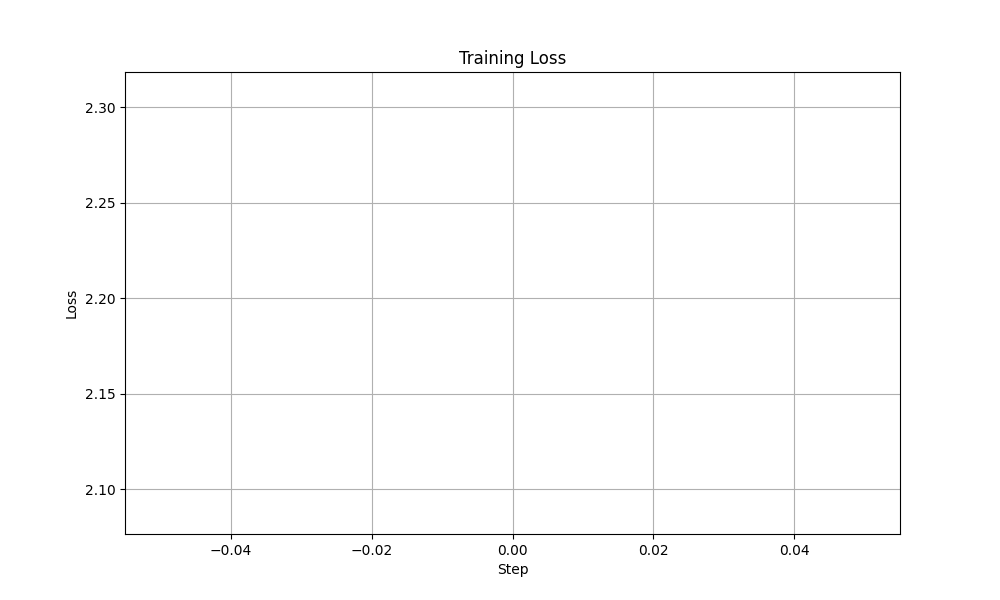

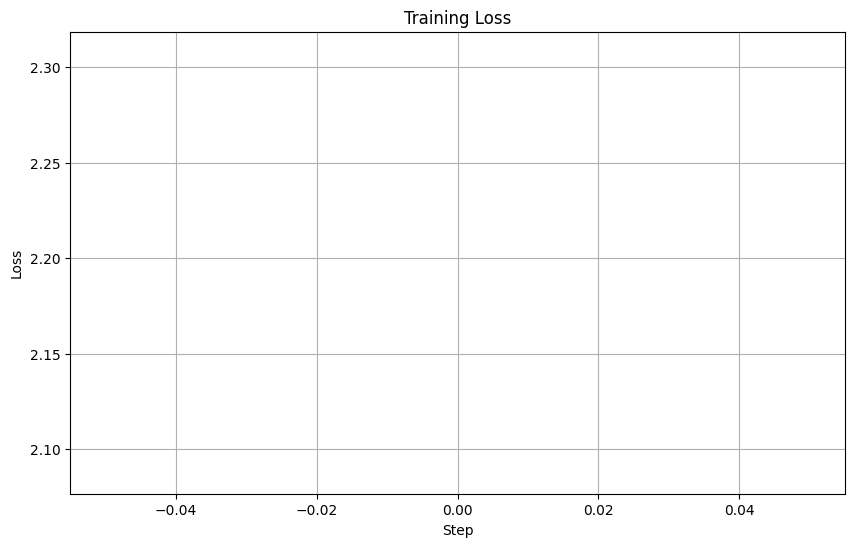

In [ ]:
# Try to run the training with improved error handling and optimal multiprocessing
try:
    # Start timer
    start_time = time.time()
    
    # Fix data types and device mismatch issues
    trainer.fix_device_mismatch()
    
    # Enable progressive loading if configured
    if hasattr(config, 'progressive_loading') and config.progressive_loading:
        trainer.enable_progressive_loading(True)
    
    # Print optimization settings
    print(f"\nTraining with optimized settings for GCP Vertex AI with L4 GPU:")
    print(f"- Number of workers: {config.num_workers}")
    print(f"- Batch size: {config.batch_size}")
    print(f"- Gradient accumulation steps: {config.gradient_accumulation_steps}")
    print(f"- Mixed precision: {config.mixed_precision}")
    
    if shm_size_gb is not None:
        print(f"- Available shared memory: {shm_size_gb:.2f} GB")
        if shm_size_gb < 8 and config.num_workers > 1:
            print("⚠️ Warning: Shared memory is limited. If you encounter errors, consider:")
            print("  - Reducing num_workers further")
            print("  - Increasing shared memory with: sudo mount -o remount,size=16G /dev/shm")
    
    # Apply adaptive settings based on shared memory
    config = adaptive_shm_handling(config)

    # First, fix the noise scheduler to handle FP16 inputs properly
    trainer = patch_noise_scheduler(trainer)

    # Enable progressive loading
    if hasattr(config, 'progressive_loading') and config.progressive_loading:
        trainer.enable_progressive_loading(True)
    
    # check model size
    print_model_size(trainer.model)
    
    # Run training with optimized settings
    print(f"03 trainer.train() started ...\n ")
    trainer.train(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        num_train_epochs=num_steps
    )
    print(f"03 trainer.train() done\n ")
    # Add memory monitoring to the trainer
    trainer = add_memory_monitoring(trainer)

    # End timer
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Average time per step: {training_time / num_steps:.2f} seconds")
    print(f"Estimated time for 30000 steps: {(training_time / num_steps) * 30000 / 3600:.2f} hours")
    
except RuntimeError as e:
    print(f"\nError during training: {str(e)}")
    
    # Check if this is a memory-related error
    error_msg = str(e).lower()
    if any(term in error_msg for term in ["memory", "cuda", "shared memory", "bus error", "dataloader worker"]):
        print("\nThis appears to be a memory-related error.")
        
        # Suggest progressive reduction of workers
        if config.num_workers > 0:
            reduced_workers = max(0, config.num_workers - 1)
            print(f"\nTry reducing num_workers from {config.num_workers} to {reduced_workers}")
            print("Add this code to your next cell:")
            print(f"config.num_workers = {reduced_workers}")
            print("trainer = CubeDiffTrainer(config=config, ...)")
        else:
            # If workers already at 0, suggest other optimizations
            print("\nSince num_workers is already 0, try these alternatives:")
            print(f"1. Reduce batch_size (currently {config.batch_size})")
            print(f"2. Increase gradient_accumulation_steps (currently {config.gradient_accumulation_steps})")
        
        if "shared memory" in error_msg or "bus error" in error_msg:
            print("\nYou can also increase shared memory on your GCP instance:")
            print("1. Open a terminal in JupyterLab")
            print("2. Run: sudo mount -o remount,size=16G /dev/shm")
            print("3. Restart the kernel and try again")
    
    # Save checkpoint if possible
    try:
        trainer.save_checkpoint(os.path.join(config.output_dir, "error_checkpoint"))
        print("Saved checkpoint at training failure point")
    except Exception as save_err:
        print(f"Could not save checkpoint: {str(save_err)}")

except Exception as e:
    print(f"\nUnexpected error: {str(e)}")
    import traceback
    traceback.print_exc()

finally:
    # Clean up wandb
    if trainer.wandb_run:
        trainer.wandb_run.finish()
        print("Finished wandb run")
    
    # Show training visualizations if available
    try:
        # Alternative to wandb.jupyter.show() since it doesn't seem to work
        loss_curve_path = os.path.join(trainer.logs_dir, 'loss_curve.png')
        if os.path.exists(loss_curve_path):
            from IPython.display import Image, display
            print("Training loss curve:")
            display(Image(filename=loss_curve_path))
        else:
            print("No loss curve found.")
    except Exception as vis_err:
        print(f"Could not show visualizations: {str(vis_err)}")

## 6. Visualize Training Progress

Since we've configured wandb in offline mode, we can visualize the training using the built-in visualization method from the trainer.

In [ ]:
# Use the trainer's built-in visualization method
try:
    trainer.show_training_visualizations()
except Exception as e:
    print(f"Could not show visualizations: {e}")

## 7. View Offline wandb Logs

We can also view the stored wandb logs directly in JupyterLab.

In [ ]:
# View wandb logs directly using wandb.jupyter.show()
# if trainer.wandb_run:
#     wandb.jupyter.show()

# Properly handle wandb offline mode visualization
# View logs locally since wandb.jupyter.show() doesn't work
# All logs will be kept on the GCP instance

# Properly finish wandb run if it's still active
if trainer.wandb_run and hasattr(trainer.wandb_run, 'id'):
    trainer.wandb_run.finish()
    print("Finished wandb run")
    
    # Print offline sync information
    run_id = trainer.wandb_run.id
    run_path = os.path.join(trainer.logs_dir, "wandb", "offline-run-" + run_id)
    if os.path.exists(run_path):
        print(f"Wandb offline run saved at: {run_path}")
        print(f"To sync later, you can run: wandb sync {run_path}")

# Display loss curve directly from saved files
loss_curve_path = os.path.join(trainer.logs_dir, 'loss_curve.png')
if os.path.exists(loss_curve_path):
    from IPython.display import Image, display
    print("Training loss curve:")
    display(Image(filename=loss_curve_path))
else:
    # Try to find loss data in CSV and plot it
    log_file = os.path.join(trainer.logs_dir, "training_log.csv")
    if os.path.exists(log_file):
        import pandas as pd
        import matplotlib.pyplot as plt
        
        print("Plotting loss from training log file...")
        logs = pd.read_csv(log_file)
        plt.figure(figsize=(10, 6))
        plt.plot(logs['step'], logs['loss'])
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.savefig(os.path.join(trainer.logs_dir, 'generated_loss_curve.png'))
        plt.show()
    else:
        print("No loss curve or training log found.")

# Display samples if available
samples_dir = os.path.join(trainer.images_dir)
if os.path.exists(samples_dir):
    sample_dirs = [d for d in os.listdir(samples_dir) if d.startswith('step_')]
    if sample_dirs:
        # Get the latest sample directory
        latest_dir = sorted(sample_dirs, key=lambda x: int(x.split('_')[1]))[-1]
        latest_samples_dir = os.path.join(samples_dir, latest_dir)
        
        # Display samples
        sample_files = [f for f in os.listdir(latest_samples_dir) if f.endswith('.jpg')]
        
        if sample_files:
            from IPython.display import Image, display
            
            print(f"\nDisplaying latest samples from {latest_dir}:")
            for sample_file in sample_files[:3]:  # Show up to 3 samples
                print(f"Sample: {sample_file}")
                display(Image(os.path.join(latest_samples_dir, sample_file)))
        else:
            print("No sample images found in the directory.")
    else:
        print("No sample directories found.")

# Display local wandb files status
try:
    wandb_dir = os.path.join(trainer.logs_dir, "wandb")
    if os.path.exists(wandb_dir):
        print("\nWandb offline files:")
        runs = [d for d in os.listdir(wandb_dir) if d.startswith('offline-run-')]
        
        if runs:
            for run in runs:
                run_path = os.path.join(wandb_dir, run)
                run_size = sum(os.path.getsize(os.path.join(dirpath, filename)) 
                            for dirpath, _, filenames in os.walk(run_path) 
                            for filename in filenames) / (1024 * 1024)  # Size in MB
                
                print(f"- {run} ({run_size:.1f} MB)")
                
                # Look for log files
                log_dir = os.path.join(run_path, "logs")
                if os.path.exists(log_dir):
                    log_files = os.listdir(log_dir)
                    if log_files:
                        print(f"  Log files: {', '.join(log_files[:3])}" + ("..." if len(log_files) > 3 else ""))
        else:
            print("No offline runs found.")
except Exception as e:
    print(f"Error checking wandb files: {e}")

## 8. Alternative: View Loss Curve Directly

If for some reason wandb visualization is not working as expected, we can view the loss curve directly from the saved files.

In [ ]:
# Load the loss curve from the logs directory
logs_dir = os.path.join(config.output_dir, "logs")
loss_curve_path = os.path.join(logs_dir, 'loss_curve.png')

if os.path.exists(loss_curve_path):
    from IPython.display import Image
    display(Image(filename=loss_curve_path))
else:
    print("Loss curve image not found.")
    
    # Check if we have training logs that we can plot
    log_file = os.path.join(logs_dir, "training_log.csv")
    if os.path.exists(log_file):
        import pandas as pd
        logs = pd.read_csv(log_file)
        plt.figure(figsize=(10, 6))
        plt.plot(logs['step'], logs['loss'])
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.show()

## 9. Check Generated Samples

Let's check if any samples were generated during training.

In [ ]:
# Check for sample images
# View any generated samples
images_dir = os.path.join(config.output_dir, "samples")
if os.path.exists(images_dir):
    sample_dirs = [d for d in os.listdir(images_dir) if d.startswith('step_')]
    if sample_dirs:
        # Get the latest sample directory
        latest_dir = sorted(sample_dirs, key=lambda x: int(x.split('_')[1]))[-1]
        latest_samples_dir = os.path.join(images_dir, latest_dir)
        
        # Display samples
        sample_files = [f for f in os.listdir(latest_samples_dir) if f.endswith('.jpg')]
        
        if sample_files:
            from IPython.display import Image, display
            
            print(f"Displaying samples from {latest_dir}:\n")
            for sample_file in sample_files:
                print(f"Sample: {sample_file}")
                display(Image(os.path.join(latest_samples_dir, sample_file)))
                print("\n")
        else:
            print("No sample images found in the directory.")
    else:
        print("No sample directories found.")
else:
    print("Samples directory not found.")

print("\nTraining Summary:")
print("=" * 50)
print(f"Dataset: {len(train_dataset)} samples")
print(f"Mini-training completed: {num_steps} steps")
print(f"Batch size: {config.batch_size}")
print(f"Workers: {config.num_workers}")
print(f"Gradient accumulation steps: {config.gradient_accumulation_steps}")
print(f"Effective batch size: {config.batch_size * config.gradient_accumulation_steps}")
print(f"Output directory: {config.output_dir}")


## 10. Test Checkpoint Loading

In [ ]:
# Get the latest checkpoint
checkpoints = [d for d in os.listdir(config.output_dir) if d.startswith('checkpoint-')]
if checkpoints:
    # Sort by step number
    checkpoints = sorted(checkpoints, key=lambda x: int(x.split('-')[1]))
    latest_checkpoint = os.path.join(config.output_dir, checkpoints[-1], "model.pt")
    
    print(f"Latest checkpoint: {latest_checkpoint}")
    
    # Load the checkpoint to test it
    if os.path.exists(latest_checkpoint):
        try:
            # Initialize a new model
            test_model = CubeDiffModel(config.pretrained_model_name)
            
            # Load the checkpoint
            test_model.load_state_dict(torch.load(latest_checkpoint, map_location="cpu"))
            
            print("Successfully loaded checkpoint")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
    else:
        print("Checkpoint file not found")
else:
    print("No checkpoints found")


## 11. Estimate Full Training Resources

Based on the mini-training, let's estimate the resources needed for full training.

In [ ]:
# Estimate full training resources
if 'training_time' in locals():
    # Estimated total training time
    total_hours = (training_time / num_steps) * 30000 / 3600
    
    # With 8-hour daily sessions
    days_needed = total_hours / 8
    
    print(f"Estimated resources for full 30,000 steps training:")
    print(f"Total training time: {total_hours:.2f} hours")
    print(f"Training days with 8-hour sessions: {days_needed:.2f} days")
    
    # Estimate GPU memory usage
    if torch.cuda.is_available():
        # Get current GPU memory usage
        memory_used = torch.cuda.max_memory_allocated(0) / 1024 / 1024 / 1024  # GB
        print(f"Peak GPU memory usage: {memory_used:.2f} GB")
        
        # Check if we need to optimize further
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1024 / 1024 / 1024  # GB
        if memory_used > 0.9 * total_memory:
            print("WARNING: Memory usage is close to capacity. Consider reducing batch size or model size.")
        else:
            print(f"Memory headroom: {(total_memory - memory_used):.2f} GB")
    
    # Estimate cost (assuming $1.25/hour for L4 GPU on GCP)
    hourly_rate = 1.25 * torch.cuda.device_count()  # Cost per hour for all GPUs
    estimated_cost = hourly_rate * total_hours
    
    print(f"Estimated cost (at ${hourly_rate:.2f}/hour): ${estimated_cost:.2f}")
    
    # Check if within budget
    daily_budget = 80  # Daily budget in dollars
    daily_cost = hourly_rate * 8  # Cost for 8 hours of training
    
    print(f"Daily cost (8 hours): ${daily_cost:.2f} (Budget: ${daily_budget})") 
    if daily_cost > daily_budget:
        print("WARNING: Daily cost exceeds budget.")
else:
    print("No training data available for estimation.")

## 12. Cleanup wandb Run

Make sure to finish the wandb run properly.

In [ ]:
# Properly finish wandb run if it's still active
if trainer.wandb_run and trainer.wandb_run.id:
    trainer.wandb_run.finish()
    print("Finished wandb run")

## 13. Next Steps

Based on this mini-training session, here are the next steps for full CubeDiff implementation:

1. **Expand the dataset**:
   - Collect and process more panorama images
   - Ensure diversity in scene types (indoor/outdoor, natural/urban)
   - Create high-quality captions for all images

2. **Optimize training parameters**:
   - Adjust learning rate and scheduling based on mini-training results
   - Fine-tune LoRA parameters for better efficiency
   - Consider gradient accumulation steps for larger effective batch size

3. **Set up long-running training**:
   - Configure automatic checkpointing for 8-hour sessions
   - Implement a robust session management system
   - Ensure training can be resumed from checkpoints

4. **Implement evaluation metrics**:
   - Face consistency measures
   - FID score for panorama quality
   - Text-image alignment metrics for conditional generation

5. **Create inference pipeline**:
   - Build an optimized inference system
   - Implement text-to-panorama and image-to-panorama modes
   - Optimize for high-resolution output